In [1]:
import os
import time
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys
sys.path.append('C:/Users/Hagar/Desktop/DeepLearningProject')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
from tensorboardX import SummaryWriter

import scipy.sparse as sp
import scipy.stats as stats
from scipy.stats import skew

import pickle

from pop_bias_metrics_basic import pred_item_rank, pred_item_score, pred_item_stdscore, pred_item_rankdist, raw_pred_score, pcc_train, pcc_test, pcc_test_check, uPO

import data_utils
import config

Using device: cpu


In [2]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '1'

## Step 1 - Initial Data Generation

### Loading Dataset and EDA

In [3]:
raw = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/ratings.dat', sep = "::", header = None, engine = 'python')
raw.columns = ['uid', 'sid', 'ratings', 'timestamp']
raw.head(5)

,uid,sid,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
# Check data types of each column
print(raw.dtypes)

uid          int64
sid          int64
ratings      int64
timestamp    int64
dtype: object


In [5]:
# Check for missing values
print(raw.isnull().sum())

uid          0
sid          0
ratings      0
timestamp    0
dtype: int64


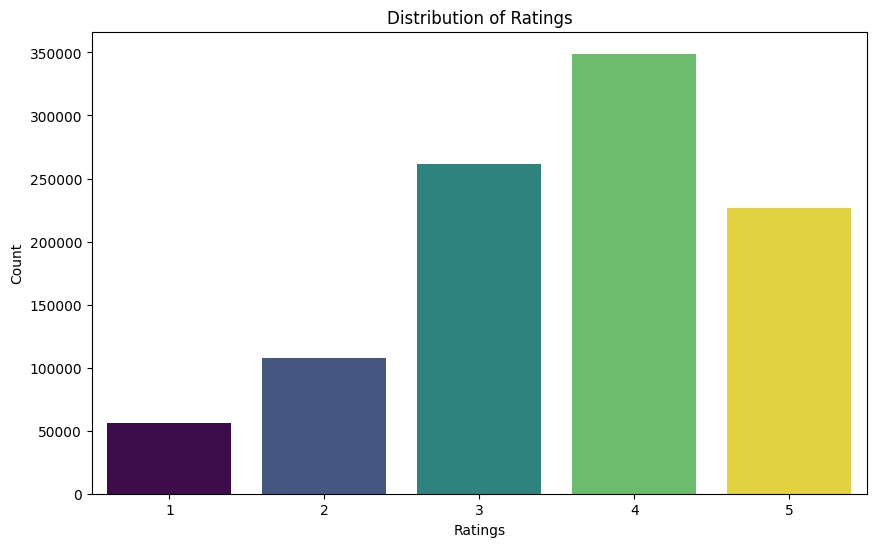

In [6]:
# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='ratings', data=raw, hue='ratings', palette='viridis', legend=False)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

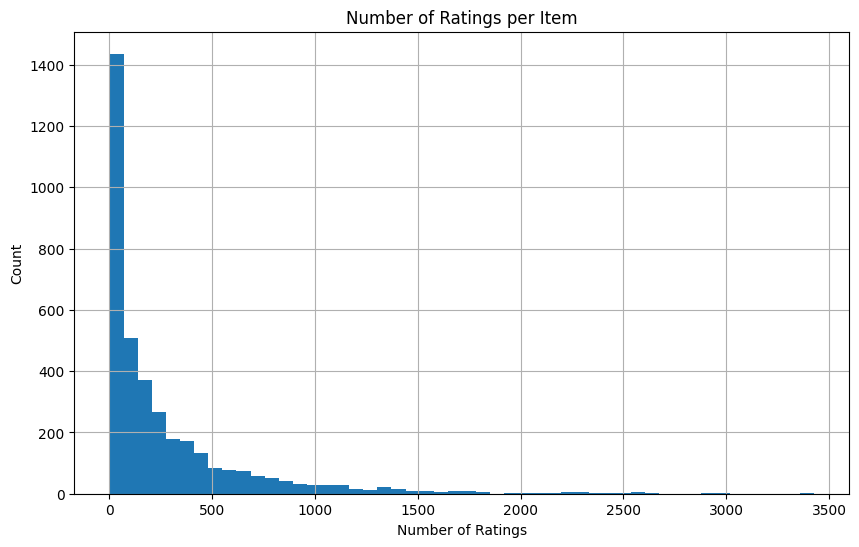

In [7]:
# Number of ratings per item
item_ratings = raw.groupby('sid').size()
plt.figure(figsize=(10, 6))
item_ratings.hist(bins=50)
plt.title('Number of Ratings per Item')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

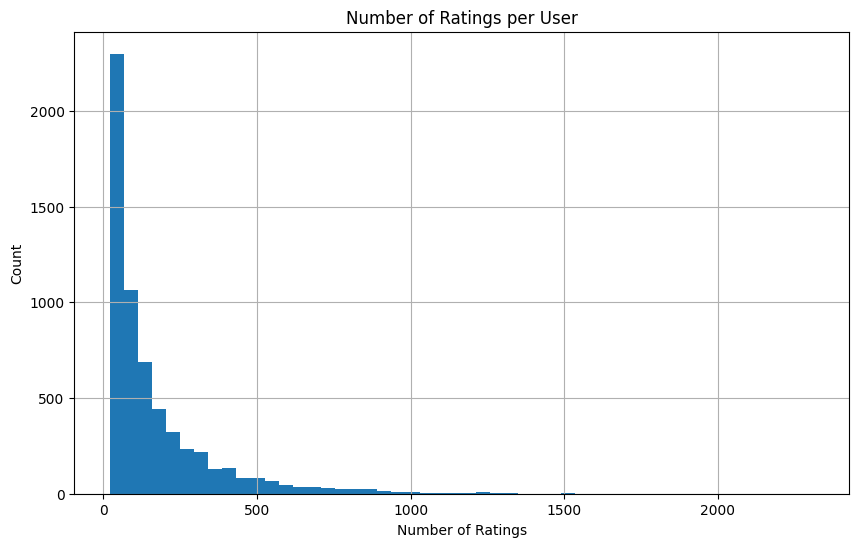

In [8]:
# Number of ratings per user
user_ratings = raw.groupby('uid').size()
plt.figure(figsize=(10, 6))
user_ratings.hist(bins=50)
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

### Preprocessing

In [9]:
# Count the occurrences of each 'sid' and filter those with counts >= 10
value_counts = raw.sid.value_counts()
filtered_counts = value_counts[value_counts >= 10]

# Reset the index to turn the Series into a DataFrame
filtered_counts = filtered_counts.reset_index()

# Rename the columns to be more explicit
filtered_counts.columns = ['sid', 'count']

# Extract the 'sid' values
new_items = filtered_counts['sid'].values

In [10]:
data = raw[raw.sid.isin(new_items)]
data = data.reset_index()[['uid', 'sid']]

### Reindex by popularity count

In [11]:
# Calculate the value counts for the 'uid' column in the 'data' DataFrame
pop_uid = data.uid.value_counts().reset_index()

# Rename the columns for clarity
pop_uid.columns = ['uid', 'uid_counts']

# Reset the index of the DataFrame to create a new sequential index
pop_uid_dict = pop_uid.reset_index()

# Select only the 'index' and 'uid' columns
pop_uid_dict = pop_uid_dict[['index', 'uid']]

# Rename the columns for clarity
pop_uid_dict.columns = ['new_uid', 'uid']

# Create a dictionary where the keys are the original 'uid' values and the values are the new 'new_uid' values
pop_uid_dict = dict(zip(pop_uid_dict.uid, pop_uid_dict.new_uid))

In [12]:
# Calculate the value counts for the 'sid' column in the 'data' DataFrame
pop_sid = data.sid.value_counts().reset_index()

# Rename the columns for clarity
pop_sid.columns = ['sid', 'sid_counts']

# Reset the index of the DataFrame to create a new sequential index
pop_sid_dict = pop_sid.reset_index()

# Select only the 'index' and 'sid' columns
pop_sid_dict = pop_sid_dict[['index', 'sid']]

# Rename the columns for clarity
pop_sid_dict.columns = ['new_sid', 'sid']

# Create a dictionary where the keys are the original 'sid' values and the values are the new 'new_sid' values
pop_sid_dict = dict(zip(pop_sid_dict.sid, pop_sid_dict.new_sid))

In [13]:
# Map the original 'uid' values in 'data' to the new 'uid' values using the 'pop_uid_dict' dictionary
data['uid'] = data.uid.map(pop_uid_dict).values

# Map the original 'sid' values in 'data' to the new 'sid' values using the 'pop_sid_dict' dictionary
data['sid'] = data.sid.map(pop_sid_dict).values

# Sort 'data' DataFrame by 'uid' and 'sid' in ascending order
data = data.sort_values(['uid', 'sid'], ascending=[True, True])

# Create a temporary DataFrame 'tmp' as a copy of 'data'
tmp = data.copy()

# Add a new column 'one' to 'tmp' DataFrame, setting all values in this column to 1
tmp['one'] = 1

In [14]:
total_data = data.reset_index()[['uid', 'sid']]

### Train and Test

In [15]:
random.seed(0)

In [16]:
train_df = total_data.sample(frac = 0.8, random_state = 0)

test_df = total_data.loc[list(set(total_data.index) - set(train_df.index)) ]

In [17]:
# Determine the number of unique users and items
n_user = len(total_data.uid.unique())
n_item = len(total_data.sid.unique())

# Create a set of all possible item indices
item_set = set(list(range(n_item)))

# Initialize an empty DataFrame to store negative samples
neg_sample_df = pd.DataFrame({'uid': [], 'sid': []})

# Loop over each user
for user in list(range(n_user)):
    # Get the set of items that the user has interacted with
    true_set = total_data[total_data['uid'] == user]['sid'].values
    true_set = set(true_set)
    
    # Determine the set of items the user has not interacted with (negative samples)
    user_neg_samples = item_set - true_set
    user_neg_samples = list(user_neg_samples)
    
    # Randomly sample 100 negative items for the user
    user_neg_samples = random.sample(user_neg_samples, 100)
    
    # Create a temporary DataFrame for the negative samples of the current user
    tmp_neg_sample_df = pd.DataFrame({'uid': [user] * 100, 'sid': user_neg_samples})
    
    # Concatenate the temporary DataFrame with the main negative sample DataFrame
    neg_sample_df = pd.concat([neg_sample_df, tmp_neg_sample_df])

In [18]:
# Ensure that the 'uid' and 'sid' columns in neg_sample_df are of integer type
neg_sample_df['uid'] = neg_sample_df['uid'].astype(int)
neg_sample_df['sid'] = neg_sample_df['sid'].astype(int)

# Add a 'type' column to test_df with all values set to 'pos' to indicate positive samples
test_df['type'] = 'pos'

# Add a 'type' column to neg_sample_df with all values set to 'neg' to indicate negative samples
neg_sample_df['type'] = 'neg'

In [19]:
test_neg_sample_df = neg_sample_df.copy()
test_df_with_neg = pd.concat([test_df, neg_sample_df])
test_df_with_neg.shape

(803708, 3)

In [20]:
train_df = train_df.reset_index()[['uid', 'sid']]
test_df = test_df.reset_index()[['uid', 'sid', 'type']]
neg_sample_df = neg_sample_df.reset_index()[['uid', 'sid', 'type']]
test_df_with_neg = test_df_with_neg.reset_index()[['uid', 'sid', 'type']]

### Creating Validation Set

In [21]:
real_train_df = train_df.sample(frac = 0.75, random_state = 0)
val_df = train_df.loc[list(set(train_df.index) - set(real_train_df.index))]

In [22]:
val_df['type'] = 'pos'
val_df_with_neg = pd.concat([val_df, neg_sample_df])

In [23]:
real_train_df = real_train_df.reset_index()[['uid', 'sid']]
val_df = val_df.reset_index()[['uid', 'sid', 'type']]
val_df_with_neg = val_df_with_neg.reset_index()[['uid', 'sid', 'type']]

### Datasets Summarize and Save to CSVs

In [24]:
test_df = test_df[['uid', 'sid', 'type']]
test_df_with_neg = test_df_with_neg[['uid', 'sid', 'type']]

In [25]:
test_df_with_neg

,uid,sid,type
0,0,1,pos
1,1034,765,pos
2,1034,782,pos
3,0,4,pos
4,1034,828,pos
...,...,...,...
803703,6039,2188,neg
803704,6039,1309,neg
803705,6039,2891,neg
803706,6039,533,neg


In [26]:
test_df.type.value_counts()

type
pos    199708
Name: count, dtype: int64

In [27]:
test_df_with_neg.type.value_counts()

type
neg    604000
pos    199708
Name: count, dtype: int64

In [28]:
total_data.shape[0] == real_train_df.shape[0] + val_df.shape[0] + test_df.shape[0]

True

In [111]:
val_df_with_neg.shape[0] == val_df.shape[0] + neg_sample_df.shape[0]

True

In [112]:
test_df_with_neg.shape[0] == test_df.shape[0] + neg_sample_df.shape[0]

True

In [113]:
total_data.to_csv('total_df', index = False)
real_train_df.to_csv('train_df', index = False)
neg_sample_df.to_csv('neg_sample_df', index = False)

val_df.to_csv('val_df', index = False)
val_df_with_neg.to_csv('val_df_with_neg', index = False)

test_df.to_csv('test_df', index = False)
test_df_with_neg.to_csv('test_df_with_neg', index = False)

In [114]:
# Calculate the total counts of each unique 'uid' in total_data DataFrame
uid_pop_total = total_data.uid.value_counts().reset_index()

# Rename the columns to 'uid' and 'total_counts' for clarity
uid_pop_total.columns = ['uid', 'total_counts']

# Save uid_pop_total DataFrame to CSV file without index column
uid_pop_total.to_csv('uid_pop_total.csv', index=False)

# Calculate the total counts of each unique 'sid' in total_data DataFrame
sid_pop_total = total_data.sid.value_counts().reset_index()

# Rename the columns to 'sid' and 'total_counts' for clarity
sid_pop_total.columns = ['sid', 'total_counts']

# Save sid_pop_total DataFrame to CSV file without index column
sid_pop_total.to_csv('sid_pop_total.csv', index=False)

# Calculate the train counts of each unique 'uid' in train_df DataFrame
uid_pop_train = train_df.uid.value_counts().reset_index()

# Rename the columns to 'uid' and 'train_counts' for clarity
uid_pop_train.columns = ['uid', 'train_counts']

# Save uid_pop_train DataFrame to CSV file without index column
uid_pop_train.to_csv('uid_pop_train.csv', index=False)

# Calculate the train counts of each unique 'sid' in train_df DataFrame
sid_pop_train = train_df.sid.value_counts().reset_index()

# Rename the columns to 'sid' and 'train_counts' for clarity
sid_pop_train.columns = ['sid', 'train_counts']

# Save sid_pop_train DataFrame to CSV file without index column
sid_pop_train.to_csv('sid_pop_train.csv', index=False)

## Step 2 - Adjacency Matrix Generation for GNN Model

In [3]:
def load_all_custom(test_num=100):
    """ 
    Loads training data from 'train_df.csv' and prepares it for further processing.

    Returns:
    sp.dok_matrix: Sparse matrix representation of user-item interactions.
    """
    train_data = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/train_df')
    train_data = train_data[['uid', 'sid']]
    train_data['uid'] = train_data['uid'].astype(int)
    train_data['sid'] = train_data['sid'].astype(int)
    train_data.columns = ['user', 'item']

    user_num = train_data['user'].max() + 1
    item_num = train_data['item'].max() + 1

    train_data = train_data.values.tolist()

    # Create a sparse matrix (DOK format) to represent user-item interactions
    train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for user, item in train_data:
        train_mat[user, item] = 1.0

    return train_mat

R = load_all_custom()

In [4]:
def create_adj_mat(user_num, item_num, R):
    """
    Creates an adjacency matrix from user-item interactions and computes normalized versions.

    Args:
    user_num (int): Number of users.
    item_num (int): Number of items.
    R (scipy.sparse.dok_matrix): Sparse matrix of user-item interactions.

    Returns:
    scipy.sparse.csr_matrix: Original adjacency matrix.
    scipy.sparse.csr_matrix: Mean normalized adjacency matrix.
    scipy.sparse.csr_matrix: Single normalized adjacency matrix.
    """
    
    t1 = time()
    adj_mat = sp.dok_matrix((user_num + item_num, user_num + item_num), dtype=np.float32)
    adj_mat = adj_mat.tolil()
    R = R.tolil()

    adj_mat[:user_num, user_num:] = R
    adj_mat[user_num:, :user_num] = R.T
    adj_mat = adj_mat.todok()
    print('Created adjacency matrix:', adj_mat.shape, time() - t1)

    t2 = time()

    def mean_adj_single(adj):
        # D^-1 * A
        rowsum = np.array(adj.sum(1))
        d_inv = np.power(rowsum, -1).flatten()
        d_inv[np.isinf(d_inv)] = 0.
        d_mat_inv = sp.diags(d_inv)
        norm_adj = d_mat_inv.dot(adj)
        print('Generated mean normalized adjacency matrix.')
        return norm_adj.tocsr()

    norm_adj_mat = mean_adj_single(adj_mat + sp.eye(adj_mat.shape[0]))

    print('Normalized adjacency matrix computation time:', time() - t2)
    return adj_mat.tocsr(), norm_adj_mat

In [121]:
# Assuming u_num and s_num are predefined
u_num = 6040
s_num = 3260
adj_mat, norm_adj_mat = create_adj_mat(u_num, s_num, R)

Created adjacency matrix: (9300, 9300) 4.257232427597046
Generated mean normalized adjacency matrix.
Normalized adjacency matrix computation time: 0.30002331733703613


In [ ]:
sp.save_npz('adj_mat.npz', adj_mat)
sp.save_npz('norm_adj_mat.npz', norm_adj_mat)

print('Saved adjacency matrices as adj_mat.npz and norm_adj_mat.npz')

## Step 3 - Epoch Negative Sample Generator

In [3]:
def load_all_custom(test_num=100, dataset=None):
    """
    Load and preprocess all necessary datasets for training or testing.

    Args:
    test_num (int, optional): Number of test samples to load (default is 100).
    dataset (str, optional): Name of the dataset (not used in the function).

    Returns:
    tuple: Tuple containing training data, test data, number of users, number of items,
           training matrix, test matrix (dummy), and total interaction matrix.

    Notes:
    - This function assumes the availability of specific CSV files ('total_df', 'train_df', 'test_df', 'val_df', 'neg_sample_df').
    - Loads user-item interaction data from CSV files and converts them into appropriate formats.
    - Constructs sparse matrices (train_mat, total_mat) to represent user-item interactions.
    """
    # Load total data containing all user-item interactions
    total_data = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/total_df')
    total_data = total_data[['uid', 'sid']]
    total_data['uid'] = total_data['uid'].apply(lambda x: int(x))
    total_data['sid'] = total_data['sid'].apply(lambda x: int(x))
    user_num = total_data['uid'].max() + 1
    item_num = total_data['sid'].max() + 1
    del total_data  # Free up memory

    # Load training data
    train_data = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/train_df')
    train_data = train_data[['uid', 'sid']]
    train_data['uid'] = train_data['uid'].apply(lambda x: int(x))
    train_data['sid'] = train_data['sid'].apply(lambda x: int(x))
    train_data = train_data.values.tolist()

    # Initialize a dok_matrix for the training matrix
    train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for x in train_data:
        train_mat[x[0], x[1]] = 1.0

    # Load test data (dummy implementation)
    test_data = None

    # Load validation data
    val_data = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/val_df')
    val_data = val_data[['uid', 'sid']]
    val_data['uid'] = val_data['uid'].apply(lambda x: int(x))
    val_data['sid'] = val_data['sid'].apply(lambda x: int(x))
    val_data = val_data.values.tolist()

    # Load negative samples data
    neg_samples_data = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/neg_sample_df')
    neg_samples_data = neg_samples_data[['uid', 'sid']]
    neg_samples_data['uid'] = neg_samples_data['uid'].apply(lambda x: int(x))
    neg_samples_data['sid'] = neg_samples_data['sid'].apply(lambda x: int(x))
    neg_samples_data = neg_samples_data.values.tolist()

    # Create total interaction matrix (includes train, test, val, and negative samples)
    total_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
    for x in train_data:
        total_mat[x[0], x[1]] = 1.0
    for x in val_data:
        total_mat[x[0], x[1]] = 1.0
    for x in neg_samples_data:
        total_mat[x[0], x[1]] = 1.0

    # Dummy code for test_data and test_mat (not used in this function)
    test_data = None
    test_mat = None

    return train_data, test_data, user_num, item_num, train_mat, test_mat, total_mat

In [4]:
class BPRData(data.Dataset):
    """
    Dataset class for Bayesian Personalized Ranking (BPR) model training and testing.

    Args:
    features (list): List of training features, where each element is a list [uid, sid] representing user-item pairs.
    num_item (int): Number of unique items in the dataset.
    train_mat (scipy.sparse.dok_matrix, optional): Sparse matrix representation of training data (default is None).
    total_mat (scipy.sparse.dok_matrix, optional): Sparse matrix containing all user-item interactions (default is None).
    num_ng (int, optional): Number of negative samples to generate for each positive pair (default is 0).
    is_training (bool, optional): Flag indicating whether the dataset is for training or testing (default is None).
    sample_mode (str, optional): Sampling mode for negative item pairs (default is None).

    Methods:
    ng_sample(): Generates negative item pairs [neg1, neg2] for each positive pair [user, pos1, pos2].
    __len__(): Returns the total number of samples in the dataset.
    __getitem__(idx): Retrieves a sample from the dataset at the given index, returning [user, pos1, pos2, neg1, neg2].
    """

    def __init__(self, features, num_item, train_mat=None, total_mat=None, num_ng=0, is_training=None, sample_mode=None):
        super(BPRData, self).__init__()
        """ Initializes the BPR dataset with provided parameters. """
        self.features = features
        self.features2 = None
        self.num_item = num_item
        self.train_mat = train_mat
        self.total_mat = total_mat
        self.num_ng = num_ng
        self.is_training = is_training
        self.sample_mode = sample_mode
        self.features_fill = []

    def ng_sample(self):
        """
        Samples negative item pairs [neg1, neg2] for each positive pair [user, pos1, pos2].

        Notes:
        - Negative sampling is performed only during training.
        - Updates self.features_fill with [user, pos1, pos2, neg1, neg2] for each sampled pair.
        """
        assert self.is_training, 'No need to sample when testing'
        
        # Prepare features2 with shuffled positive items and sampled negative items
        tmp = pd.DataFrame(self.features)
        tmp.columns = ['uid', 'sid']
        tmp = tmp.sort_values('uid')
        tmp_list = list(range(tmp.shape[0]))
        random.shuffle(tmp_list)
        tmp['rng'] = tmp_list
        sid2 = tmp.sort_values(['uid', 'rng']).sid
        tmp['sid2'] = sid2.reset_index().sid
        tmp = tmp[['uid', 'sid', 'sid2']]
        tmp = tmp.sort_index()
        self.features2 = tmp.values.tolist()
        
        # Sample negative items until both neg1 and neg2 are not in total_mat
        for x in self.features2:
            u, pos1, pos2 = x[0], x[1], x[2]
            for t in range(self.num_ng):
                neg1, neg2 = np.random.randint(self.num_item, size=2)
                while ((u, neg1) in self.total_mat) or ((u, neg2) in self.total_mat):
                    neg1, neg2 = np.random.randint(self.num_item, size=2)
                self.features_fill.append([u, pos1, pos2, neg1, neg2])

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        int: Number of samples if training, else length of features (positive samples).
        """
        return self.num_ng * len(self.features) if self.is_training else len(self.features)

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset at the given index.

        Args:
        idx (int): Index of the sample to retrieve.

        Returns:
        tuple: Tuple containing [user, pos1, pos2, neg1, neg2] for training, or [user, pos1, pos2] for testing.
        """
        features = self.features_fill if self.is_training else self.features
        user = features[idx][0]
        pos1 = features[idx][1]
        pos2 = features[idx][2]
        neg1 = features[idx][3]
        neg2 = features[idx][4] if len(features[idx]) > 3 else None
        return user, pos1, pos2, neg1, neg2

In [ ]:
train_data, test_data, user_num, item_num, train_mat, test_mat, total_mat = load_all_custom()

In [133]:
print('original user-pos tuple is')
train_data[0:10]

original user-pos tuple is


[[660, 307],
 [941, 493],
 [451, 249],
 [4633, 2489],
 [926, 542],
 [1296, 694],
 [713, 1033],
 [110, 619],
 [5901, 486],
 [820, 2180]]

In [134]:
train_dataset = BPRData(train_data, item_num, train_mat, total_mat, num_ng=1, is_training=True, sample_mode=None)

In [135]:
train_dataset.ng_sample()

In [136]:
negative_samples = train_dataset.features_fill

In [137]:
print('new (user, pos1, pos2, neg1, neg2) tuple is')
negative_samples[0:10]

new (user, pos1, pos2, neg1, neg2) tuple is


[[660, 307, 2654, 330, 3212],
 [941, 493, 852, 1855, 2409],
 [451, 249, 20, 1777, 51],
 [4633, 2489, 2229, 2923, 1438],
 [926, 542, 2188, 970, 2900],
 [1296, 694, 1149, 685, 156],
 [713, 1033, 1996, 2887, 1151],
 [110, 619, 2823, 2808, 1957],
 [5901, 486, 1952, 1201, 2631],
 [820, 2180, 135, 981, 437]]

In [138]:
tmp1 = np.array(negative_samples)[:, 1]
tmp2 = np.array(negative_samples)[:, 2]

In [139]:
print('ratio of pos1 > pos2')
print(np.mean(tmp1 > tmp2))

ratio of pos1 > pos2
0.49971207915569926


### Generate Epoch Training Data for Faster, Reproducible Training

In [31]:
total_epochs = 14
num_ng = 3

In [ ]:
# Loop over total_epochs
for i in range(total_epochs):
    print(i)  # Print the current epoch number
    train_list = []  # Initialize an empty list to store training samples
    
    # Loop over num_ng (number of negative samples per positive sample)
    for j in range(num_ng):
        train_dataset.ng_sample()  # Sample negative examples using ng_sample method
        train_samples = train_dataset.features_fill  # Get the sampled training samples
        train_list += train_samples  # Append the samples to the train_list
    
    # Save the collected training samples to a pickle file
    with open(f'C:/Users/Hagar/Desktop/DeepLearningProject/pickels/train_samples_{i}', 'wb') as fp:
        pickle.dump(train_list, fp)

## Step 4 - Model Definition

In [5]:
import model_basic

## Step 5 - Model Evalutation

In [6]:
import evaluate

Using device: cpu


## Step 6 - Model Training

In [7]:
#pip install torch torchvision torchaudio

In [8]:
import argparse
import os

import torch.backends.cudnn as cudnn
import data_utils 
import torch.utils.data as data

In [9]:
parser = argparse.ArgumentParser(allow_abbrev=False)

# Model parameters
parser.add_argument("--lr", type=float, default=0.001, help="learning rate")
parser.add_argument("--dropout", type=float, default=0.0, help="dropout rate")
parser.add_argument("--batch_size", type=int, default=256, help="batch size for training")
parser.add_argument("--epochs", type=int, default=20, help="training epochs")
parser.add_argument("--top_k", type=int, default=10, help="compute metrics@top_k")
parser.add_argument("--factor_num", type=int, default=64, help="predictive factors numbers in the model")
parser.add_argument("--num_layers", type=int, default=3, help="number of layers in MLP model")
parser.add_argument("--num_ng", type=int, default=3, help="sample negative items for training")
parser.add_argument("--test_num_ng", type=int, default=99, help="sample part of negative items for testing")

# Other options
parser.add_argument("--out", default=True, help="save model or not")
parser.add_argument("--gpu", type=str, default="1", help="gpu card ID")
parser.add_argument("--dataset", type=str, default="movielens", help="dataset name")
parser.add_argument("--model", type=str, default='MLP', help="model type: MLP, MF, NCF")
parser.add_argument("--sample", type=str, default="none", help="sample type: none, macr")
parser.add_argument("--weight", type=float, default=0.5, help="weight")
parser.add_argument("--burnin", type=str, default="no", help="burnin: yes, no")
parser.add_argument("--reg", type=str, default='no', help="regularization: yes, no")
args, unknown = parser.parse_known_args()

val_results = []

# Set CUDA device
#os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
#cudnn.benchmark = True

In [10]:
raw_train_data = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/train_df')    
val_data_without_neg = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/val_df')    
val_data_with_neg = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/val_df_with_neg')    
test_data_without_neg = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/test_df')    
test_data_with_neg = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/test_df_with_neg')    
                        
sid_pop_total = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/sid_pop_total.csv')
sid_pop_train = pd.read_csv('C:/Users/Hagar/Desktop/DeepLearningProject/sid_pop_train.csv')

In [11]:
train_data, test_data, user_num, item_num, train_mat, test_mat, total_mat = load_all_custom()

In [12]:
train_data_len = len(train_data)

In [13]:
train_dataset = data_utils.BPRData(train_data_len*args.num_ng)
train_loader = data.DataLoader(train_dataset,batch_size=args.batch_size, shuffle=True, num_workers=4)

In [14]:
GMF_model = None
MLP_model = None

In [15]:
# Model selection based on args.model and args.sample
if args.model == 'MLP':
    model = model_basic.BPR(user_num, item_num, args.factor_num, args.num_layers,
                            args.dropout, args.model, GMF_model, MLP_model)
elif args.model == 'MF':
    if args.sample == 'macr':
        model = model_basic.MF_MACR(user_num, item_num, args.factor_num, args.num_layers,
                                    args.dropout, args.model, GMF_model, MLP_model)
    else:
        model = model_basic.MF_BPR(user_num, item_num, args.factor_num, args.num_layers,
                                   args.dropout, args.model, GMF_model, MLP_model)
elif args.model == 'NCF':
    if args.sample == 'macr':
        model = model_basic.NCF_MACR(user_num, item_num, args.factor_num, args.num_layers,
                                     args.dropout, args.model, GMF_model, MLP_model)
    else:
        model = model_basic.NCF(user_num, item_num, args.factor_num, args.num_layers,
                                args.dropout, args.model, GMF_model, MLP_model)
else:
    raise ValueError(f"Unsupported model type: {args.model}")

# Move model to CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr)

In [16]:
sid_pop_train_dict = dict(list(zip(sid_pop_train.sid, sid_pop_train.train_counts)))

print(args.dataset, ' ', args.model, ' ', args.sample, ' ', args.weight, ' ', 'reg', args.reg, 'burnin', args.burnin)
print('entered training')
count, best_hr = 0, 0

sample = args.sample
acc_w = args.weight
pop_w = 1-args.weight

movielens   MLP   none   0.5   reg no burnin no
entered training


In [30]:
args.epochs=2

In [31]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move model to device
model.to(device)

# Initialize lists to store evaluation metrics
HR_list, NDCG_list, ARP_list = [], [], []
PCC_TEST_list, SCC_score_test_list, SCC_rank_test_list = [], [], []
upo_list, mean_test_list, skew_test_list = [], [], []

# Training loop
for epoch in range(args.epochs):
    #print('epoch is : ', epoch)
    model.train()
    start_time = time.time()
    
    train_loader.dataset.get_data(args.dataset, epoch)
    model.to(device)  # Move model to device

    if epoch < args.epochs / 4:
        if args.burnin == 'yes':
            sample = 'none'
    elif epoch >= args.epochs / 4:
        sample = args.sample

    if args.sample in ['none', 'posneg']:
        for user, pos1, pos2, neg1, neg2 in train_loader:
            pos, neg = pos1, neg1
            _, _ = pos2, neg2

            user = user.to(device)
            pos = pos.to(device)
            neg = neg.to(device)
            model.zero_grad()

            pos_scores, neg_scores = model(user, pos, neg)
            if args.sample == 'none':
                loss = - (pos_scores - neg_scores).sigmoid().log().mean()
            elif args.sample == 'posneg':
                acc_loss = - (pos_scores - neg_scores).sigmoid().log().mean() / 2
                pop_loss = -(1 - (pos_scores + neg_scores).abs().tanh()).log().mean() / 2
                loss = acc_loss * acc_w + pop_loss * pop_w
            if args.reg == 'yes':
                user_emb_w = model.embed_user_MLP.weight[user]
                pos_emb_w = model.embed_item_MLP.weight[pos]
                neg_emb_w = model.embed_item_MLP.weight[neg]
                reg = (torch.norm(user_emb_w) ** 2 + torch.norm(pos_emb_w) ** 2 + torch.norm(neg_emb_w) ** 2) / 3 / args.batch_size
                loss += 1e-5 * reg
            loss.backward()
            optimizer.step()

    elif args.sample in ['pd']:
        for user, pos1, pos2, neg1, neg2 in train_loader:
            pos, neg = pos1, neg1
            _, _ = pos2, neg2

            user = user.to(device)
            pos = pos.to(device)
            neg = neg.to(device)
            model.zero_grad()

            pos1_label = pos1.cpu().tolist()
            neg1_label = neg1.cpu().tolist()
            pos1_map = [sid_pop_train_dict[key] for key in pos1_label]
            neg1_map = [sid_pop_train_dict[key] for key in neg1_label]

            pos1_weight = torch.from_numpy(np.array(pos1_map)).to(device)
            neg1_weight = torch.from_numpy(np.array(neg1_map)).to(device)

            pos_scores, neg_scores = model(user, pos, neg)
            m = nn.ELU()
            loss = - ((m(pos_scores) + 1.0) * pos1_weight ** (acc_w) - (m(neg_scores) + 1.0) * neg1_weight ** (acc_w)).sigmoid().log().mean()
            if args.reg == 'yes':
                user_emb_w = model.embed_user_MLP.weight[user]
                pos_emb_w = model.embed_item_MLP.weight[pos]
                neg_emb_w = model.embed_item_MLP.weight[neg]
                reg = (torch.norm(user_emb_w) ** 2 + torch.norm(pos_emb_w) ** 2 + torch.norm(neg_emb_w) ** 2) / 3 / args.batch_size
                loss += 1e-5 * reg
            loss.backward()
            optimizer.step()

    # Add other sampling strategies here (pos2neg2, pos2, neg2, ipw, macr, pearson)

    # Evaluation during training
    model.eval()
    #print('entered val evaluated')
    HR, NDCG, ARP = evaluate.metrics_custom_new_bpr(model, val_data_with_neg, args.top_k, sid_pop_total, user_num)
    PCC_TEST = pcc_test(model, val_data_without_neg, sid_pop_total, item_num)
    score = pred_item_score(model, val_data_without_neg, sid_pop_total)
    SCC_score_test = stats.spearmanr(score.dropna()['sid_pop_count'].values, score.dropna()['pred'].values)
    rank = pred_item_rank(model, val_data_without_neg, sid_pop_total)
    SCC_rank_test = stats.spearmanr(rank.dropna()['sid_pop_count'].values, rank.dropna()['rank'].values)
    upo = uPO(model, val_data_without_neg, sid_pop_total)
    rankdist = pred_item_rankdist(model, val_data_without_neg, sid_pop_total)
    mean_test = np.mean(rankdist[rankdist.notna()].values)
    skew_test = skew(rankdist[rankdist.notna()].values)

    elapsed_time = time.time() - start_time

    # Append metrics to lists for averaging later
    HR_list.append(np.mean(HR))
    NDCG_list.append(np.mean(NDCG))
    ARP_list.append(np.mean(ARP))
    PCC_TEST_list.append(np.round(PCC_TEST, 3))
    SCC_score_test_list.append(np.round(SCC_score_test[0], 3))
    SCC_rank_test_list.append(np.round(SCC_rank_test[0], 3))
    upo_list.append(np.round(upo, 3))
    mean_test_list.append(np.round(mean_test, 3))
    skew_test_list.append(np.round(skew_test, 3))

    epoch_val_result = [args.batch_size, epoch, args.sample, args.weight, np.mean(HR), np.mean(NDCG), np.mean(ARP), np.round(PCC_TEST, 3), np.round(SCC_score_test[0], 3), np.round(SCC_rank_test[0], 3), np.round(upo, 3), np.round(mean_test, 3), np.round(skew_test, 3)]
    val_results.append(epoch_val_result)

# Calculate average scores across all epochs
avg_HR = np.mean(HR_list)
avg_NDCG = np.mean(NDCG_list)
avg_ARP = np.mean(ARP_list)
avg_PCC_TEST = np.mean(PCC_TEST_list)
avg_SCC_score_test = np.mean(SCC_score_test_list)
avg_SCC_rank_test = np.mean(SCC_rank_test_list)
avg_upo = np.mean(upo_list)
avg_mean_test = np.mean(mean_test_list)
avg_skew_test = np.mean(skew_test_list)

# After training, evaluate on test set
print(f"End. Average scores across epochs: HR = {avg_HR:.3f}, NDCG = {avg_NDCG:.3f}, ARP = {avg_ARP:.3f}")

End. Average scores across epochs: HR = 0.626, NDCG = 0.369, ARP = 11771.520
